# Project: Manchester United: after Sir Alex Ferguson's age

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

Sir Alex Ferguson, former manager of Machester United Football Club, is considered one of the greatest managers of all time, and he has won more trophies than any other manager in the history of football. After he retired in 2013, Manchester United FC faces a very difficult time when his successors failed to keep the club on the winning streak. In this report, we will try to investigate what differences between Ferguson's ManU and post-Ferguson's ManU. 

This report will try to answer the following questions:

1. Is ManU weaker after Fergie's time based on the number of goals for and goals against?

2. Does ManU change the attacking stategy? 

In order to answer above questions, we use the soccer database comes from Kaggle. This database is well suited for data analysis and machine learning. It contains data for soccer matches, players, and teams from several European countries from 2008 to 2016. 

The database provides:
* +25,000 matches
* +10,000 players
* 11 European Countries with their lead championship
* Seasons 2008 to 2016
* Players and Teams' attributes* sourced from EA Sports' FIFA video game series, including the weekly updates
* Team line up with squad formation (X, Y coordinates)
* Betting odds from up to 10 providers
* Detailed match events (goal types, possession, corner, cross, fouls, cards etc…) for +10,000 matches

In [1]:
import pandas as pd
import numpy as np 
import xml.etree.ElementTree as ET
import sqlite3
import matplotlib.pyplot as plt

%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling


### Load data

> We will use `sqlite3` package to load data from the given `database.sqlite` file.

In [2]:
conn = sqlite3.connect('database.sqlite')

tables = pd.read_sql("""SELECT *
                        FROM sqlite_master
                        WHERE type='table';""", conn)
tables

,type,name,tbl_name,rootpage,sql
0,table,sqlite_sequence,sqlite_sequence,4,"CREATE TABLE sqlite_sequence(name,seq)"
1,table,Player_Attributes,Player_Attributes,11,"CREATE TABLE ""Player_Attributes"" (\n\t`id`\tIN..."
2,table,Player,Player,14,CREATE TABLE `Player` (\n\t`id`\tINTEGER PRIMA...
3,table,Match,Match,18,CREATE TABLE `Match` (\n\t`id`\tINTEGER PRIMAR...
4,table,League,League,24,CREATE TABLE `League` (\n\t`id`\tINTEGER PRIMA...
5,table,Country,Country,26,CREATE TABLE `Country` (\n\t`id`\tINTEGER PRIM...
6,table,Team,Team,29,"CREATE TABLE ""Team"" (\n\t`id`\tINTEGER PRIMARY..."
7,table,Team_Attributes,Team_Attributes,2,CREATE TABLE `Team_Attributes` (\n\t`id`\tINTE...


There are 8 tables and we need to pull out ManU's information from those. First, let's have a look at `Team` table

In [3]:
teams = pd.read_sql("""SELECT *
                        FROM Team
                        ORDER BY team_long_name;
                    """, conn)
teams.head()

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
0,16848,8350,29.0,1. FC Kaiserslautern,KAI
1,15624,8722,31.0,1. FC Köln,FCK
2,16239,8165,171.0,1. FC Nürnberg,NUR
3,16243,9905,169.0,1. FSV Mainz 05,MAI
4,11817,8576,614.0,AC Ajaccio,AJA


Let's find Manchester United from those

In [4]:
teams[teams['team_long_name'].str.contains('Manchester')]

,id,team_api_id,team_fifa_api_id,team_long_name,team_short_name
161,3466,8456,10.0,Manchester City,MCI
162,3457,10260,11.0,Manchester United,MUN


Base on the above, we see that Manchester United `team_api_id=10260`. We will use this `team_api_id` to pull out ManU's information.

In [5]:
MU_id = teams[teams['team_long_name'].str.contains('Manchester United')]['team_api_id'].iloc[0]
MU_id 

10260

Now we want to pull out ManU's matches, let's have a look at the `Match` table

In [6]:
ManU = pd.read_sql("""
                      SELECT *
                      FROM Match
                      WHERE home_team_api_id == %s or away_team_api_id ==%s
                   """ %(MU_id,MU_id),conn)
ManU.head()

,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1729,1729,1729,2008/2009,1,2008-08-17 00:00:00,489042,10260,10261,1,...,10.00,1.28,5.5,12.00,1.30,4.75,10.00,1.29,4.5,11.00
1,1739,1729,1729,2008/2009,10,2008-10-29 00:00:00,489132,10260,8654,2,...,17.00,1.20,6.1,19.00,1.20,6.00,13.00,1.22,5.5,12.00
2,1749,1729,1729,2008/2009,11,2008-11-01 00:00:00,489142,10260,8667,4,...,19.00,1.17,7.0,19.00,1.18,6.00,17.00,1.17,6.5,13.00
3,1759,1729,1729,2008/2009,12,2008-11-08 00:00:00,489152,9825,10260,2,...,2.38,3.25,3.2,2.35,3.00,3.20,2.35,3.30,3.2,2.25
4,1769,1729,1729,2008/2009,13,2008-11-15 00:00:00,489162,10260,10194,5,...,19.00,1.14,6.5,13.00,1.15,7.50,16.00,1.14,6.5,17.00


### General Properties

In [7]:
ManU.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304 entries, 0 to 303
Columns: 115 entries, id to BSA
dtypes: float64(33), int64(72), object(10)
memory usage: 273.2+ KB


### Data Cleaning

* The original data contains 304 features, most of them we don't need. In this report, to answer the questions we are interested in, we use the following features:
(`season`, `date`,`home_team_api_id`, `away_team_api_id`, `home_team_goal`, `away_team_goal`, `goal`)

* We will use the `xml` text in the `goal` feature to extract the scoring time.
* We will use the `xml` text in the `possession` feature to extract the possession percentage in each match.

In [8]:
ManU = ManU[['season', 'date','home_team_api_id', 'away_team_api_id', 'home_team_goal', 'away_team_goal', 'goal','possession']]
ManU.head()

,season,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,goal,possession
0,2008/2009,2008-08-17 00:00:00,10260,10261,1,1,<goal><value><comment>n</comment><stats><goals...,<possession><value><comment>56</comment><event...
1,2008/2009,2008-10-29 00:00:00,10260,8654,2,0,<goal><value><comment>n</comment><stats><goals...,<possession><value><comment>59</comment><event...
2,2008/2009,2008-11-01 00:00:00,10260,8667,4,3,<goal><value><comment>n</comment><stats><goals...,<possession><value><comment>59</comment><event...
3,2008/2009,2008-11-08 00:00:00,9825,10260,2,1,<goal><value><comment>dg</comment><event_incid...,<possession><value><comment>62</comment><event...
4,2008/2009,2008-11-15 00:00:00,10260,10194,5,0,<goal><value><comment>n</comment><stats><goals...,<possession><value><comment>59</comment><event...


We define:
 - `get_score_time` function to extract score time
 - `home_possession` function to extract possession percentage for the home team
 
**Important note**: in the raw data, there are many goal types which is encoded by `dg, n, npm, o, p, psm, rp`. However, only types `n,o,p` are actually goals. 

In [9]:
def get_score_time(xml):
    root = ET.XML(xml)
    goal_for = []
    goal_against = []
    if len(root.getchildren())>0:
        for goal in root.getchildren():
            tags = [i.tag for i in goal]
            if 'goal_type' in tags: 
                if list(goal.iter('goal_type'))[0].text in 'nop' and int(list(goal.iter('team'))[0].text) == MU_id:
                    goal_for.append(int(list(goal.iter('elapsed'))[0].text))
                else:
                    goal_against.append(int(list(goal.iter('elapsed'))[0].text))
    return goal_for

In [10]:
def home_possession(xml):
    root = ET.XML(xml)
    return int(list(root.iter('homepos'))[-1].text)

In [11]:
ManU['score_time'] = ManU['goal'].apply(lambda x: get_score_time(x))
ManU['possession'] = ManU['possession'].apply(lambda x: home_possession(x))

In [12]:
ManU.drop(['goal'],axis=1,inplace=True)
ManU.head()

,season,date,home_team_api_id,away_team_api_id,home_team_goal,away_team_goal,possession,score_time
0,2008/2009,2008-08-17 00:00:00,10260,10261,1,1,55,[24]
1,2008/2009,2008-10-29 00:00:00,10260,8654,2,0,60,"[14, 30]"
2,2008/2009,2008-11-01 00:00:00,10260,8667,4,3,51,"[3, 29, 44, 57]"
3,2008/2009,2008-11-08 00:00:00,9825,10260,2,1,52,[90]
4,2008/2009,2008-11-15 00:00:00,10260,10194,5,0,58,"[4, 45, 49, 84, 89]"


<a id='eda'></a>
## Exploratory Data Analysis


### Is ManU weaker after Fergie's time based on the number of goals for and goals against?

* It's not eay to answer this question, however, we can have a rough idea by looking at the number of goals for and number of goals against over the seasons and observe their changes.  
* We also look at the average possession percentage in each season in order to see if Manchester United reduces its ball controlling time

**Important** Since in the data, in each match, Manchester United is either home team or away team. Let `home` to be 1 if Mancherter United is the home team and 0 if Manchester United is the away team. Then we can determine `home` by
<div align=center> `home = (home_team_api_id==MU_id)` </div>

And then in the observed match, Manchester United's number of goals can be calculated using

<div align=center> `home*home_team_goal + (1-home)*away_team_goal` </div>

In [13]:
ManU['goal_for'] = ManU.apply(lambda x: (x['home_team_api_id']==MU_id)*x['home_team_goal']+
                                (1-(x['home_team_api_id']==MU_id))*x['away_team_goal'],axis=1 ) 
ManU['goal_against'] = ManU.apply(lambda x: (x['home_team_api_id']!=MU_id)*x['home_team_goal']+
                                (1-(x['home_team_api_id']!=MU_id))*x['away_team_goal'],axis=1 )
ManU.drop(['home_team_api_id','away_team_api_id','home_team_goal','away_team_goal'],axis=1,inplace=True)
ManU.head()

,season,date,possession,score_time,goal_for,goal_against
0,2008/2009,2008-08-17 00:00:00,55,[24],1,1
1,2008/2009,2008-10-29 00:00:00,60,"[14, 30]",2,0
2,2008/2009,2008-11-01 00:00:00,51,"[3, 29, 44, 57]",4,3
3,2008/2009,2008-11-08 00:00:00,52,[90],1,2
4,2008/2009,2008-11-15 00:00:00,58,"[4, 45, 49, 84, 89]",5,0


In [14]:
season = ManU.groupby('season').agg({'goal_for':'sum','goal_against':'sum','possession':'mean'})
season

,goal_for,goal_against,possession
season,,,
2008/2009,68,24,52.131579
2009/2010,86,28,52.473684
2010/2011,78,37,51.078947
2011/2012,89,33,53.210526
2012/2013,86,43,51.026316
2013/2014,64,43,50.131579
2014/2015,62,37,52.052632
2015/2016,49,35,51.763158


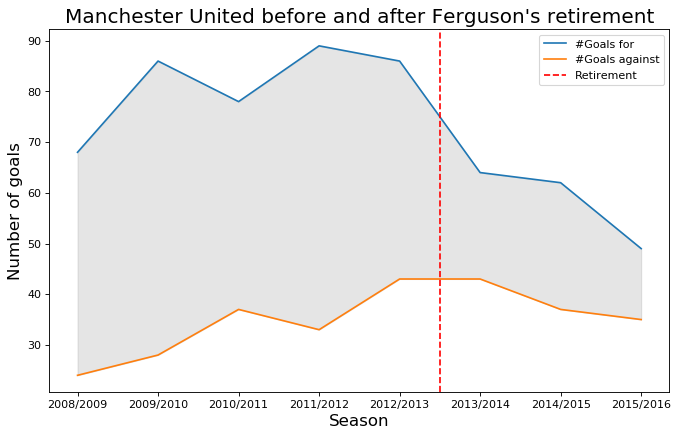

In [15]:
plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')

plt.plot(season.index,season['goal_for'])
plt.plot(season.index,season['goal_against'])
plt.axvline(x=4.5,ls='--',color='r')
plt.fill_between(season.index,season['goal_for'],season['goal_against'],color='grey',alpha=0.2)
plt.legend(['#Goals for','#Goals against','Retirement'])
plt.title('''Manchester United before and after Ferguson's retirement''',fontsize=18);
plt.xlabel('Season',fontsize=15)
plt.ylabel('Number of goals',fontsize=15);

So by the graph above, we see that the number of goals Manchester United had scored descreased quickly after Sir Alex Ferguson retired. This might show that the attacking line is weaker. Now we will investigate the possession

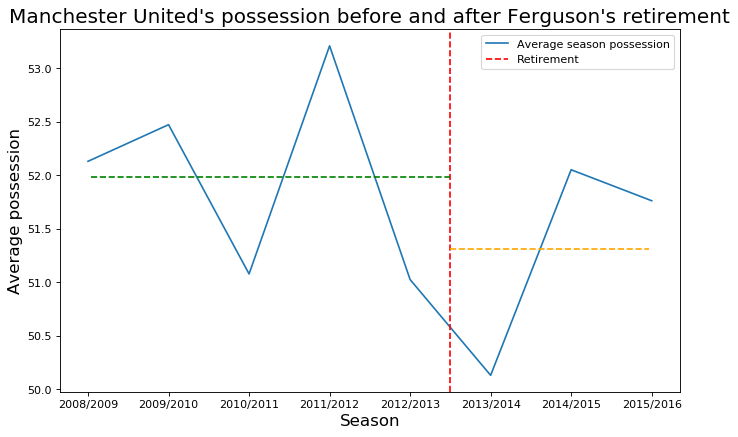

In [16]:
plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.plot(season.index,season['possession']);
plt.axvline(x=4.5,ls='--',color='r')
plt.legend(['Average season possession','Retirement'])
plt.title('''Manchester United's possession before and after Ferguson's retirement''',fontsize=18);
plt.xlabel('Season',fontsize=15)
plt.ylabel('Average possession',fontsize=15);
before = season.loc[:'2012/2013']['possession'].mean()
after = season.loc['2013/2014':]['possession'].mean()
plt.axhline(y=before,xmin=0.05,xmax=0.63,ls='--',color='green')
plt.axhline(y=after,xmin=0.63,xmax=0.95,ls='--',color='orange');

So obviously that Manchester United losing its ball controlling time after Sir Alex Ferguson retired.

### Does ManU change the attacking stategy?
* This is also a hard question that is not easy to answer. We will try to give a simple idea using the number of goals Manchester United scored in 6 time intervals: 

<div align="center">
`[0,15),[15,30),[30,45),[45,60),[60,75),[75,90]`
</div>

In [17]:
ManU['[0,15)'] = ManU['score_time'].apply(lambda x: sum([i in range(0,15) for i in x]))
ManU['[15,30)'] = ManU['score_time'].apply(lambda x: sum([i in range(15,30) for i in x]))
ManU['[30,45)'] = ManU['score_time'].apply(lambda x: sum([i in range(30,45) for i in x]))
ManU['[45,60)'] = ManU['score_time'].apply(lambda x: sum([i in range(45,60) for i in x]))
ManU['[60,75)'] = ManU['score_time'].apply(lambda x: sum([i in range(60,75) for i in x]))
ManU['[75,90]'] = ManU['score_time'].apply(lambda x: sum([i in range(75,91) for i in x]))
interval_df = ManU[['season','[0,15)','[15,30)','[30,45)','[45,60)','[60,75)','[75,90]']]
interval_df.head()

,season,"[0,15)","[15,30)","[30,45)","[45,60)","[60,75)","[75,90]"
0,2008/2009,0,1,0,0,0,0
1,2008/2009,1,0,1,0,0,0
2,2008/2009,1,1,1,1,0,0
3,2008/2009,0,0,0,0,0,1
4,2008/2009,1,0,0,2,0,2


In [18]:
intervals = interval_df.groupby('season').sum()
intervals['total'] = intervals.sum(axis=1)
intervals

,"[0,15)","[15,30)","[30,45)","[45,60)","[60,75)","[75,90]",total
season,,,,,,,
2008/2009,8,13,8,9,16,15,69
2009/2010,3,5,13,17,13,25,76
2010/2011,10,10,10,12,14,20,76
2011/2012,9,14,12,17,18,19,89
2012/2013,13,16,12,12,13,17,83
2013/2014,3,11,11,16,11,12,64
2014/2015,8,14,9,10,8,12,61
2015/2016,4,7,6,12,8,11,48


Compute the percentage of goals in each intervals

In [19]:
for col in list(intervals.columns)[:-1]:
    intervals[col] = intervals[col]/intervals['total']
intervals

,"[0,15)","[15,30)","[30,45)","[45,60)","[60,75)","[75,90]",total
season,,,,,,,
2008/2009,0.115942,0.188406,0.115942,0.130435,0.231884,0.217391,69
2009/2010,0.039474,0.065789,0.171053,0.223684,0.171053,0.328947,76
2010/2011,0.131579,0.131579,0.131579,0.157895,0.184211,0.263158,76
2011/2012,0.101124,0.157303,0.134831,0.191011,0.202247,0.213483,89
2012/2013,0.156627,0.192771,0.144578,0.144578,0.156627,0.204819,83
2013/2014,0.046875,0.171875,0.171875,0.250000,0.171875,0.187500,64
2014/2015,0.131148,0.229508,0.147541,0.163934,0.131148,0.196721,61
2015/2016,0.083333,0.145833,0.125000,0.250000,0.166667,0.229167,48


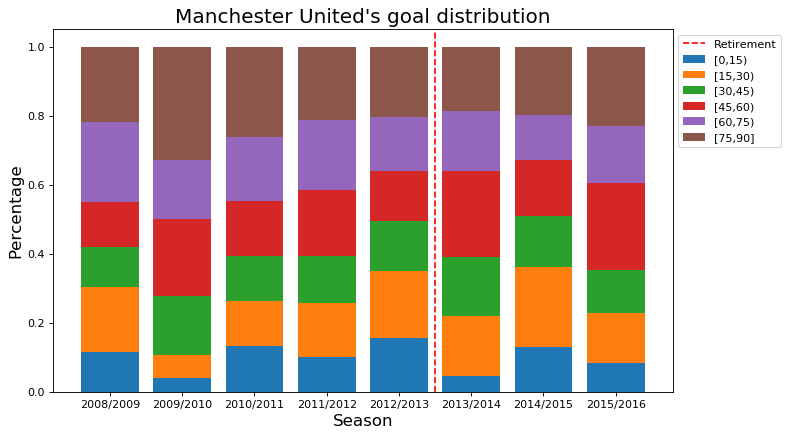

In [20]:
plt.figure(figsize=(10, 6), dpi= 80, facecolor='w', edgecolor='k')
plt.bar(intervals.index,intervals['[0,15)'])
plt.bar(intervals.index,intervals['[15,30)'],bottom = intervals['[0,15)'])
plt.bar(intervals.index,intervals['[30,45)'],bottom = intervals[['[0,15)','[15,30)']].sum(axis=1))
plt.bar(intervals.index,intervals['[45,60)'],bottom = intervals[['[0,15)','[15,30)','[30,45)']].sum(axis=1))
plt.bar(intervals.index,intervals['[60,75)'],bottom = intervals[['[0,15)','[15,30)','[30,45)','[45,60)']].sum(axis=1))
plt.bar(intervals.index,intervals['[75,90]'],bottom = intervals[['[0,15)','[15,30)','[30,45)','[45,60)','[60,75)']].sum(axis=1))
plt.axvline(x=4.5,ls='--',color='r')
plt.legend(['Retirement','[0,15)','[15,30)','[30,45)','[45,60)','[60,75)','[75,90]'],bbox_to_anchor=(1, 1))
plt.xlabel('Season',fontsize=15)
plt.ylabel('Percentage',fontsize=15);
plt.title('''Manchester United's goal distribution''',fontsize=18);

So by the plot we see that:
* Before Sir Alex Ferguson's retirement, Manchester United seems to put their best in final minutes and actually they are famous about that characteristic.

* After Sir Alex Ferguson's retirement, Manchester United seems to be effective in attacking after the break time.

<a id='conclusions'></a>
## Conclusions

Although we chose questions that are not easy to answer, the investigation suggests the following:

**Question 1:** Is ManU weaker after Fergie's time based on the number of goals for and goals against?
* The number of goals Manchester United had scored descreased quickly after Sir Alex Ferguson retired. This might show that the attacking line is weaker. 
*  Manchester United is losing its ball controlling time after Sir Alex Ferguson retired

**Question 2:** Does ManU change the attacking stategy?
* Before Sir Alex Ferguson's retirement, Manchester United seems to put their best in final minutes and actually they are famous about that characteristic.

* After Sir Alex Ferguson's retirement, Manchester United seems to be effective in attacking after the break time.

## References

1. Ismael Gomez, https://www.kaggle.com/bustami/in-which-minute-do-teams-score/code
2. Dima Rudov, https://www.kaggle.com/dimarudov/data-analysis-using-sql
3. Deepesh Nair, https://towardsdatascience.com/processing-xml-in-python-elementtree-c8992941efd2
